In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from lib.Stream import Stream, BipartiteStream
from lib.TimeNode import TimeNode, TimeNodeSet
from lib.StreamProperties import StreamStarSat
from lib.patterns import *
from lib.similarities import *
import logging
import ujson as json
from IPython.display import Image, clear_output

## Stream graph data format

Stream graphs are described as JSON files (see `./tests/integration/fixtures/` for examples), containing the different sets $T$ (the time interval of the whole stream), $V$ (the set of nodes), $W$ (the set of nodes' presences in time), $E$ (the set of edges) and $I$ (the attribute language). If the stream is bipartite, $V$, instead of a single set, contains a dictionary with two keys `left` and `right`, both containing the respective sets of nodes. If $W$ is empty, it is assumed that all nodes of $V$ are present over the full interval $T$.

Similarly for the attribute language $I$: if we are considering bipatterns, we have two keys `left` and `right` corresponding to the attributes associated.

### Bipatterns on bipartite stream
As an example, we show here one bipartite stream formatted for bipatterns enumeration:

In [10]:
basename = "Bipattern-ChangingNeighbours-StSa"
json.load(open(f"./tests/integration/fixtures/{basename}.json"))

{'settings': {'bipartite': 1, 'weighted': 0, 'directed': 0, 'attributed': 0},
 'T': {'alpha': 0, 'omega': 10},
 'V': {'left': ['u', 'x', 'y'], 'right': ['v']},
 'W': {},
 'E': [{'b': 1,
   'e': 5,
   'u': 'u',
   'v': 'v',
   'label': {'left': ['a', 'b', 'c', 'd'], 'right': ['w', 'x']}},
  {'b': 1,
   'e': 3,
   'u': 'x',
   'v': 'v',
   'label': {'left': ['a', 'b', 'c'], 'right': ['w', 'x']}},
  {'b': 2,
   'e': 4,
   'u': 'y',
   'v': 'v',
   'label': {'left': ['a', 'b', 'd'], 'right': ['w', 'x']}}],
 'I': {'left': ['a', 'b', 'c', 'd'], 'right': ['w', 'x', 'y', 'z']}}

And the corresponding stream:

6 4 (150 percent improvement) 


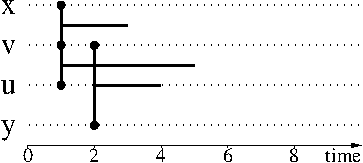

In [11]:
bip_s = BipartiteStream(_loglevel=logging.DEBUG)
core_property = StreamStarSat(bip_s, threshold=2)
bip_s.setCoreProperty(core_property)
bip_s.readStream(f"./tests/integration/fixtures/{basename}.json")
bip_s.draw()

### Patterns on unipartite stream

Similarly, let us show an example of a toy unipartite stream on which we are interested in (mono)patterns.

In [12]:
# MonoPattern test
basename = "3links-StSa-dupl"
json.load(open(f"./tests/integration/fixtures/{basename}.json"))

{'T': {'alpha': 0, 'omega': 10},
 'V': ['u', 'v', 'x', 'y'],
 'W': {},
 'E': [{'b': 1,
   'e': 6,
   'u': 'u',
   'v': 'v',
   'label_u': 'abc',
   'label_v': 'bcd'},
  {'b': 2, 'e': 4, 'u': 'v', 'v': 'x', 'label_u': 'abc', 'label_v': 'bcd'},
  {'b': 2, 'e': 4, 'u': 'v', 'v': 'y', 'label_u': 'abc', 'label_v': 'bcd'},
  {'b': 5, 'e': 6, 'u': 'v', 'v': 'x', 'label_u': 'abc', 'label_v': 'bcd'},
  {'b': 5, 'e': 6, 'u': 'v', 'v': 'y', 'label_u': 'abc', 'label_v': 'bcd'}],
 'I': ['a', 'b', 'c', 'd']}

11 6 (183 percent improvement) 


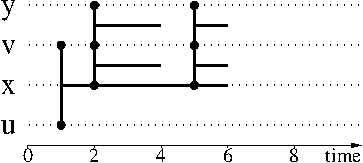

In [13]:
s = Stream(lang=set("abcd"), _loglevel=logging.DEBUG)
core_property = StreamStarSat(s, threshold=2)
s.setCoreProperty(core_property)
# s.readStream("./tests/integration/fixtures/ChangingNeighbours-StSa-Copy1.json")
s.readStream(f"./tests/integration/fixtures/{basename}.json")

s.draw()

## Interiors, core properties and pattern enumeration

In [14]:
res_int = interior(s)
res_b_int = interior(bip_s)
res_int, res_b_int

(T: {'alpha': 0, 'omega': 10}
 V: {'x', 'y', 'v', 'u'},
 W: {u;[2,4], u;[5,6], v;[2,4], v;[5,6], x;[2,4], x;[5,6], y;[2,4], y;[5,6]},
 E: (2, 4, v, x)
 (2, 4, v, y)
 (5, 6, v, x)
 (5, 6, v, y)        ,
 T: {'alpha': 0, 'omega': 10}
 V: {'left': {'x', 'y', 'u'}, 'right': {'v'}},
 W: {u;[1,4], v;[1,4], x;[1,3], y;[2,4]},
 E: (1, 4, u, v)
 (1, 3, x, v)
 (2, 4, y, v)        )

In [31]:
# Move to Stream etc. class
def mydraw(s, q, node_clusters=[]):
    basename = "ChangingNeighbours-StSa-Copy1"
    pattern_str = ''.join(sorted(q))
    
    s_draw = StreamFig.StreamFig(alpha=0, omega=5, streaming=False)
    _ = [s_draw.addNode(x) for x in s.nodes()]
    for l in s.E:
        if set([l["u"], l["v"]]) == set(["v", "y"]):
            s_draw.addLink(l["u"], l["v"], l["b"], l["e"], curving=0.2)
        else:
            s_draw.addLink(l["u"], l["v"], l["b"], l["e"])

    for nc in node_clusters:
        v, b, e, color = nc
        s_draw.addNodeCluster(v, [(b, e)], color=color)
    # s_draw.addTimeLine(ticks=2)
    s_draw.save(f"{basename}-{pattern_str}.fig")
    # For display
    from subprocess import call
    call(f"rm {basename}-{pattern_str}.png", shell=True)
    call(f"fig2dev -Lpng {basename}-{pattern_str}.fig > {basename}-{pattern_str}.png", shell=True)
    call(f"rm {basename}-{pattern_str}.fig", shell=True)
    
    return f"{basename}-{pattern_str}.png"


#my_nc = [ (x.node, x.b, x.e, 11) for x in res_int[0] ] 
#my_nc += [ (x.node, x.b, x.e, 12) for x in res_int[1] ] 
#mydraw(s, set('ab'), node_clusters=my_nc)

In [32]:
patterns(s)

{'b', 'a'} {u;[1,4], v;[1,4], x;[1,3], y;[2,4]}
{'b', 'c', 'a'} {u;[1,3], v;[1,3], x;[1,3]}
{'b', 'd', 'a'} {u;[2,4], v;[2,4], y;[2,4]}


In [35]:
result = bipatterns(bip_s)

b|a, x|w {u;[1,4], v;[1,4], x;[1,3], y;[2,4]}
b|c|a, x|w {u;[1,3], v;[1,3], x;[1,3]}
b|d|a, x|w {u;[2,4], v;[2,4], y;[2,4]}


In [36]:
result

[(b|a, x|w {u;[1,4], v;[1,4], x;[1,3], y;[2,4]}, set()),
 (b|c|a, x|w {u;[1,3], v;[1,3], x;[1,3]},
  {'left': {'a', 'b'}, 'right': {'w', 'x'}}),
 (b|d|a, x|w {u;[2,4], v;[2,4], y;[2,4]},
  {'left': {'a', 'b'}, 'right': {'w', 'x'}})]

In [37]:
bip_s.draw()

ValueError: No image data found. Expecting filename, url, or data.

In [19]:
p, q = bip_s.bipatterns_list[1][0], bip_s.bipatterns_list[1][0]
print(p,q)

b|c|a, x|w {u;[1,3], v;[1,3], x;[1,3]} b|c|a, x|w {u;[1,3], v;[1,3], x;[1,3]}


In [24]:
bipattern_similarity(bip_s, p, q)

0.0

In [28]:
# Move to patterns.py as draw_pattern_lattice ?

outf = open("bipatterns.dot", "w+")

print("digraph bips {", file=outf)

nodes = [ bp for bp in s.bipatterns_list]
edges = []

for x in s.bipatterns_list:
    bp, bp_parent = x
    basename = "ChangingNeighbours-StSa-Copy1"
    pattern_str = ''.join(sorted(bp.lang))
    
    subs = s.substream(bp.support_set[0], bp.support_set[1])
    
    my_nc = [ (x.node, x.b, x.e, 11) for x in bp.support_set[0] ] 
    my_nc += [ (x.node, x.b, x.e, 12) for x in bp.support_set[1] ]
    fname = mydraw(subs, bp.lang, node_clusters=my_nc)
    print(f'{pattern_str}[shape="plaintext", image="{basename}-{pattern_str}.png", label="{pattern_str}", labelloc="b", imagepos="tc"];', file=outf)
    
    edges.append((pattern_str, ''.join(sorted(bp_parent))))

for e in edges:
    if not (e[0] == '' or e[1] == ''):
        print(f'{e[1]} -> {e[0]}', file=outf)
print("}", file=outf)
outf.close()
from subprocess import call
call(f"dot -Tps bipatterns.dot -o outfile.ps", shell=True)

TypeError: 'Stream' object is not subscriptable